# Misagh Mohaghegh - 810199484

Artificial Intelligence CA4: *Naive Bayes*  
In this assignment, we will predict the class of a news using naive bayes classifier.

## News Labels

All news are put in the following 6 categories.  
A map from the news label text to the news type is also created.

In [1]:
from enum import Enum


class NewsLabel(Enum):
    health = 1,
    political = 2,
    sports = 3,
    technology = 4,
    art = 5,
    accidents = 6


label_map = {
    'سلامت': NewsLabel.health,
    'سیاسی': NewsLabel.political,
    'ورزشی': NewsLabel.sports,
    'فناوری': NewsLabel.technology,
    'فرهنگی/هنری': NewsLabel.art,
    'حوادث': NewsLabel.accidents
}

We will now read the training and testing data.

In [2]:
import pandas

data_train = pandas.read_csv('Dataset/train.csv')
data_test = pandas.read_csv('Dataset/test.csv')

## Part 1: Preprocessing Data

Here, the train and test data are normalized using various methods such as removing stop words and punctuation, stemming and lemmatization.

**Q1. Stemming and Lemmatization**  
Stemming and lemmatization are two methods for text normalization (transforming text into a canonical form for easier natural language processing).  
They both reduce words and extract their base form. How they reduce is where they differ.

*Stemming:*  
This is often removing letters from the start or end of a single word without considering the context or the meaning of the word.  
The resulting word is called the word stem and may not always be a valid root of the word and may lead to incorrect words or meanings.  
The process is fast but not much accurate.

*Lemmatization:*  
This is the process of determining the lemma or dictionary form of a word based on its intended meaning.  
Unlike stemming, lemmatization considers the context and the meaning of the word and converts it to a meaningful root.  
The process is slow but is very accurate.

The normalization process does the following work:

- The text is normalized using Hazm (which does a lot of the work such as unifying numerals to persian numbers, fixing the spacing and punctuation, removing extra spaces, and changing some word to their persian equivalent)  
- The text is tokenized for further changes. The Hazm tokenizer splits the parenthesis and punctuation as well.  
- The punctuation, parenthesis, and stop words are removed.  
- Each word is lemmatized.  
- The stop words are removed once again. This is because mostly, only base form of the words are in the stop-word list and we only have the base forms after lemmatizing. And since lemmatization is slow, some stop words were removed in the previous step to speed up the process.

Both the training and the testing data are normalized.

In [3]:
import hazm


class Normalizer:
    def __init__(self):
        self.lem = hazm.Lemmatizer()
        self.norm = hazm.Normalizer()
        self.token = hazm.WordTokenizer()

        self.stopwords_file = set(hazm.stopwords_list())
        self.stopwords_additional = set()  # {'ایران'}
        self.stopwords = self.stopwords_file | self.stopwords_additional

        self.punctuations = {"'", '"', '.', ',', '،', ':', ';', '؛', '?', '!',
                             '«', '»', '(', ')', '[', ']', '{', '}'}
        self.punc_and_stop = self.stopwords | self.punctuations

    def normalize(self, text: str) -> list[str]:
        res = self.norm.normalize(text)
        res = self.token.tokenize(res)
        res = [w for w in res if w not in self.punc_and_stop]
        res = [self.lem.lemmatize(w).split('#', 1)[0] for w in res]
        res = [w for w in filter(None, res) if w not in self.stopwords]
        return res


norm = Normalizer()

for i, row in enumerate(data_train.itertuples()):
    data_train.iloc[i].content = norm.normalize(row.content)
for i, row in enumerate(data_test.itertuples()):
    data_test.iloc[i].content = norm.normalize(row.content)

## Part 2: A. Naive Bayes

The naive bayes formula is implemented.

Firstly, the dataset is categorized, which means a map is made from the news label to all of the available content with that label. (The content sentence turned into a list of normalized words in the previous step)  
The `NaiveBayes` class takes the categorized training data and calculates the following:
- `label_total_word_count`: A map from each news label to how many words are in every content with that label.  
- `label_word_count`: A map from each news label to all of the words in the contents that had the label. Each word is also mapped to the number of occurrences it had.
- `total_count`: The total count of all of the words in all contents.

It offers a `classify` method which will predict which news label its input `content` has.  
Sum of logarithms is used instead of multiplying the probabilities because the number becomes extremely small and is considered 0 due to the way floating-points are.

In [4]:
import math

data_train_cat = {x: [] for x in NewsLabel}
for row in data_train.itertuples():
    data_train_cat[label_map[row.label]].append(row.content)

data_test_cat = {x: [] for x in NewsLabel}
for row in data_test.itertuples():
    data_test_cat[label_map[row.label]].append(row.content)


class NaiveBayes:
    total_word_count: dict[NewsLabel, int]
    label_word_count: dict[NewsLabel, dict[str, int]]
    total_count: int

    def __init__(self, data_train: dict[NewsLabel, list[list[str]]]):
        self.total_word_count = {x: 0 for x in NewsLabel}
        self.label_word_count = {x: {} for x in NewsLabel}
        self._count(data_train)
        self.total_count = sum(self.total_word_count.values())

    def _count(self, data_train: dict[NewsLabel, list[list[str]]]):
        for type, content_list in data_train.items():
            for content in content_list:
                for word in content:
                    self.total_word_count[type] += 1
                    if word in self.label_word_count[type]:
                        self.label_word_count[type][word] += 1
                    else:
                        self.label_word_count[type][word] = 1

    def classify(self, content: list[str]) -> NewsLabel:
        label_prob = {x: 0 for x in NewsLabel}
        for label in NewsLabel:
            prob = math.log2(self.total_word_count[label] / self.total_count)
            for word in content:
                if word in self.label_word_count[label]:
                    prob += math.log2(self.label_word_count[label][word] / self.total_word_count[label])
                else:
                    prob = -math.inf
                    break
            label_prob[label] = prob

        if max(label_prob.values()) == -math.inf:
            return None
        return max(label_prob, key=label_prob.get)

    def classify_smoothing(self, content: list[str]) -> NewsLabel:
        label_prob = {x: 0 for x in NewsLabel}
        for label in NewsLabel:
            prob = math.log2(self.total_word_count[label] / self.total_count)
            for word in content:
                if word in self.label_word_count[label]:
                    prob += math.log2((1 + self.label_word_count[label][word]) /
                                     (self.total_word_count[label] + len(self.label_word_count[label])))
                else:
                    prob += math.log2(1 / (self.total_word_count[label] + len(self.label_word_count[label])))
            label_prob[label] = prob

        return max(label_prob, key=label_prob.get)


bayes = NaiveBayes(data_train_cat)

**Q2. Bayes' Theorem**  

$$ P(c|x) = \frac{P(x|c)P(c)}{P(x)} $$
$$ P(c|x) = P(x_1|c) \times P(x_2|c) \times \ldots \times P(x_n|c) \times P(c) $$

- `[P(c|x)]` Posterior Probability:  
  The probability of **c** after observing **x**.  
  In this example, it is the probability of being in class (news label) **c** if it contains the word **x**.
- `[P(x|c)]` Likelihood:  
  The probability of **x** given **c**.  
  This is the probability of seeing word **x** in class **c**,  
  which is the number of **x** appearances in class **c** divided by the total words in class **c**.
- `[P(c)]` Class Prior Probability:  
  The probability of **c** without any given conditions (the probability of being in the **c** class by default)  
  This is the number of **c** classes divided by the total dataset entries.
- `[P(x)]` Evidence (Predictor Prior Probability):  
  The probability of **x** without any given conditions (the probability of word **x** appearing)  
  This is the count of word **x** in the dataset divided by the total word count.

## Part 2: B. Bigrams

**Q3. Bigram Example**

- The bat scared him.  
- He grabbed the bat.  

Using only unigrams, the two bats cannot be distinguished.  
Using bigrams, the first bat comes with the word *scared* which gives a hint that it's referring to the animal.  
The second bat comes with the *grab* verb which gives us a hint about baseball bats.

A bigram is enough in this case and a longer n-gram is not required.

## Part 2: C. Additive Smoothing

**Q4. Why does the probability become 0**  
When a word does not exist in a news label dataset, the probability of the word being in that label is considered zero.  
Recall the Naive Bayes formula; since all of the terms (the probability for each word being in a class) are multiplied together, if one of them is zero, then the whole result becomes zero.  
This means that if a word does not exist in a label dataset, the probability of a news being in that label and having the word is considered zero.  

**Q5. Additive Smoothing**  
A solution to the previous problem is additive smoothing, or laplace smoothing.  
The likelihood `[P(x|c)]` will be calculated as follows:

$$ P(x|c) = \frac{α + number\ of\ x\ appearances\ in\ class\ c}{total\ words\ in\ class\ c + α \times unique\ words\ in\ class\ c} $$

*α* is the parameter for additive smoothing.  
Now if a word does not exist in a class, the probability will not be zero and the class will not be immediately discarded.  
The higher the α is, the closer the probabilities will get to a uniform distribution.  
Since we do not want that, we will use an α of 1 to only make the probability not equal zero.

## Part 2: D. Correctness Checking

**Q6. Word Occurrence Bar Plot**

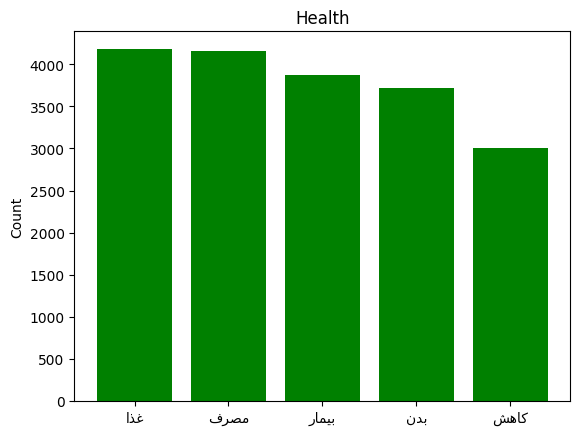

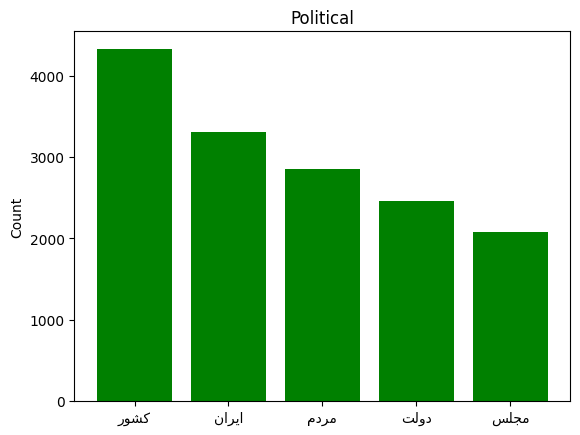

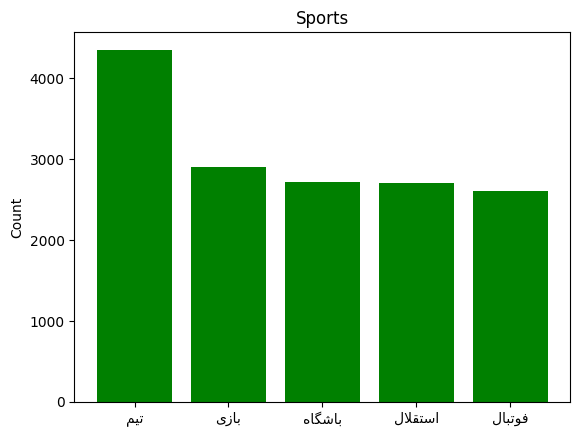

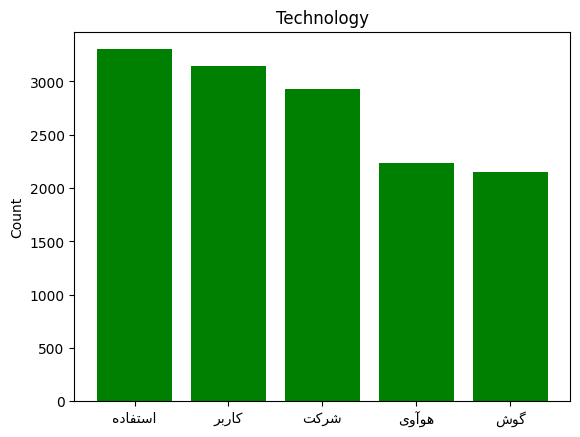

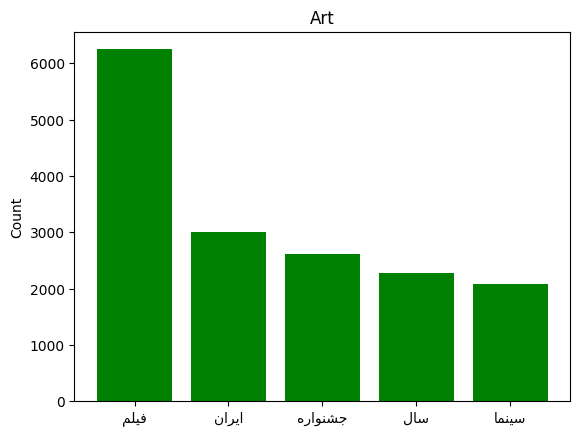

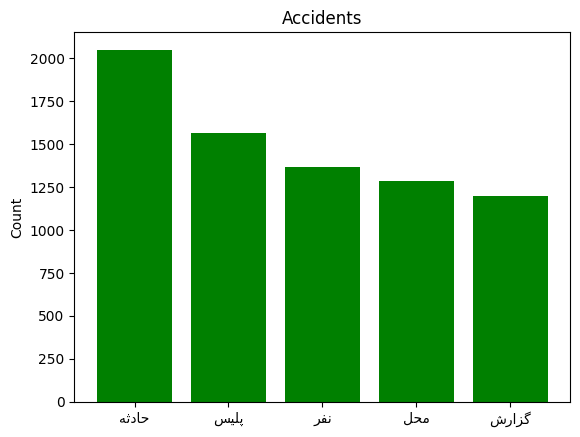

In [5]:
import matplotlib.pyplot as plt

from arabic_reshaper import reshape
from bidi.algorithm import get_display

dframe = pandas.DataFrame(bayes.label_word_count)
for label in dframe:
    top5 = dframe[label].nlargest(5)
    words = [get_display(reshape(word)) for word in top5.index]
    plt.bar(words, top5, color='green')
    plt.ylabel("Count")
    plt.title(label.name.capitalize())
    plt.show()

The top 5 words with the most occurrences in each label:
- Health:
  1. Ghaza
  2. Masraf
  3. Bimar
  4. Badan
  5. Kahesh
- Political:
  1. Keshvar
  2. Iran
  3. Mardom
  4. Dolat
  5. Majles
- Sports:
  1. Team
  2. Bazi
  3. Bashgah
  4. Esteghlal
  5. Football
- Technology:
  1. Estefade
  2. Karbar
  3. Sherkat
  4. Huawei
  5. Ghosh *(the i is dropped due to lemmatization)*
- Art:
  1. Film
  2. Iran
  3. Jashnvareh
  4. Sal
  5. Cinema
- Accidents:
  1. Hadeseh
  2. Police
  3. Nafar
  4. Mahal
  5. Gozaresh

Some words, such as *Iran* are used in multiple labels (Political and Art)  
Such words are not much useful and removing them may help the classification process.

## Part 3: Evaluation

**Q7. Evaluation Metrics**  
4 metrics are used for evaluation:

$$
Accuracy = \frac{total\ correctly\ detected}{total\ entries},\,
Precision = \frac{correctly\ detected\ in\ class}{detected\ ones\ in\ class}
$$
$$
Recall = \frac{correctly\ detected\ in\ class}{total\ entries\ in\ class},\,
F1 = 2*\frac{Precision \times Recall}{Precision + Recall}
$$


Precision is how much it can detect the class correctly between everything that it has predicted to be in the class.   
Recall is how much it can detect the class correctly between everything that is actually in the class.

If we have for example, 100 *health* labeled news, and the agent detects only 10 but guesses them all correctly, we have a precision of 100%  
But this alone does not mean much because the recall is only 10% and the agent could not get most of them.

Similarly, we can have a high recall but low accuracy.  
If we have for example, 10 *health* labeled news, and the agent detects all 10 correctly, but also predicts all other news to also be in the *health* category, we have a 100% recall, but the precision will be very low.

Therefore, only using one of the two metrics is not enough.

**Q8. F1 Score**  
The F1 score is the harmonic mean (an alternative to the usual arithmetic mean) of precision and recall.  
This combines and averages the two previously discussed metrics into a single rate, but it gives a larger weight to the lower one.

**Q9. Metric Averages**  
- **Macro Avg** is the average of a metric (precision, recall, or F1) for each class in a multi-class model.  
- **Weighted Avg** is the weighted average of a metric for each class, where the weight of each class is the number of samples in that class.  
- **Micro Avg** is the metric if all classes were one.  
  For micro average precision, we have to divide the total correctly detected by everything that was detected.  
  Micro average recall also becomes the same as micro average precision. (this is because an error (identifying class A as class B) is a false positive for class B, and a false negative for class A)  
  Therefore, micro average F1 is also the same, and the result is the accuracy:  
  ***Micro-Precision = Micro-Recall = Micro-F1 = Accuracy***

In the results, the macro/weighted/micro **F1 score** average is calculated.

**Q10. Calculating Metrics**

In [6]:
from dataclasses import dataclass
from typing import Callable


@dataclass
class Evaluation:
    accuracy: float
    precision: dict[NewsLabel, float]
    recall: dict[NewsLabel, float]
    f1_score: dict[NewsLabel, float]
    macro_avg: float
    micro_avg: float
    weighted_avg: float


def evaluator(classifier_function: Callable[[list[str]], NewsLabel]) -> Evaluation:
    correct_in_class = {x: 0 for x in NewsLabel}
    identified_as_class = {x: 0 for x in NewsLabel}
    not_identified_in_class = {x: 0 for x in NewsLabel}

    precision = {x: 0 for x in NewsLabel}
    recall = {x: 0 for x in NewsLabel}
    f1_score = {x: 0 for x in NewsLabel}

    for label in NewsLabel:
        correct = 0
        not_identified = 0

        for content in data_test_cat[label]:
            identified = classifier_function(content)
            if identified is None:
                not_identified += 1
                continue
            if identified == label:
                correct += 1
            identified_as_class[identified] += 1

        correct_in_class[label] = correct
        not_identified_in_class[label] = not_identified

    accuracy = sum(correct_in_class.values()) / len(data_test)
    for label in NewsLabel:
        recall[label] = correct_in_class[label] / len(data_test_cat[label])
        precision[label] = correct_in_class[label] / identified_as_class[label]
        if correct_in_class[label] == 0:
            f1_score[label] = 0
        else:
            f1_score[label] = 2 * precision[label] * recall[label] / (precision[label] + recall[label])

    macro_avg = sum(f1_score.values()) / len(NewsLabel)
    weighted_avg = sum([f1_score[label] * len(data_test_cat[label]) for label in NewsLabel]) / len(data_test)
    micro_avg = accuracy

    return Evaluation(accuracy, precision, recall, f1_score, macro_avg, micro_avg, weighted_avg)


eval_bayes = evaluator(bayes.classify)
eval_smooth = evaluator(bayes.classify_smoothing)

In [7]:
def display_eval(evaluation_result: Evaluation):
    res_cols = [*(x.name.capitalize() for x in NewsLabel), 'All Classes']
    res_rows = ['Precision', 'Recall', 'F1-score', 'Accuracy', 'Macro Avg', 'Micro Avg', 'Weighted Avg']
    result = pandas.DataFrame(index=res_rows, columns=res_cols)

    for x in NewsLabel:
        result.loc['Precision', x.name.capitalize()] = evaluation_result.precision[x]
        result.loc['Recall', x.name.capitalize()] = evaluation_result.recall[x]
        result.loc['F1-score', x.name.capitalize()] = evaluation_result.f1_score[x]

    result.loc['Accuracy', 'All Classes'] = evaluation_result.accuracy
    result.loc['Macro Avg', 'All Classes'] = evaluation_result.macro_avg
    result.loc['Micro Avg', 'All Classes'] = evaluation_result.micro_avg
    result.loc['Weighted Avg', 'All Classes'] = evaluation_result.weighted_avg
    
    display(result)

print("Without additive smoothing:")
display_eval(eval_bayes)
print("With additive smoothing:")
display_eval(eval_smooth)

Without additive smoothing:


,Health,Political,Sports,Technology,Art,Accidents,All Classes
Precision,0.923077,0.818182,0.955556,0.708333,0.847826,0.875,NaN
Recall,0.135593,0.225,0.226316,0.10119,0.216667,0.14,NaN
F1-score,0.236453,0.352941,0.365957,0.177083,0.345133,0.241379,NaN
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN,0.175785
Macro Avg,NaN,NaN,NaN,NaN,NaN,NaN,0.286491
Micro Avg,NaN,NaN,NaN,NaN,NaN,NaN,0.175785
Weighted Avg,NaN,NaN,NaN,NaN,NaN,NaN,0.288899


With additive smoothing:


,Health,Political,Sports,Technology,Art,Accidents,All Classes
Precision,0.971429,0.892019,0.984043,0.957055,0.969325,0.906103,NaN
Recall,0.960452,0.95,0.973684,0.928571,0.877778,0.965,NaN
F1-score,0.965909,0.920097,0.978836,0.942598,0.921283,0.934625,NaN
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN,0.943498
Macro Avg,NaN,NaN,NaN,NaN,NaN,NaN,0.943891
Micro Avg,NaN,NaN,NaN,NaN,NaN,NaN,0.943498
Weighted Avg,NaN,NaN,NaN,NaN,NaN,NaN,0.943566


**Q11. Smoothing Results**  
Without additive smoothing, the recall and accuracy are very low. This is because of the issue addressed in question 4.  
Many of the test news have words that are not in the training data and this makes the bayes classifier not identify it in any class because all of the probabilities are 0.  
In the case that all of the words do exist, it does identify it mostly correctly, which is why the precision is high.

**Q12. Wrongly Identified**

In [8]:
def print_wrongs(classifier_function: Callable[[list[str]], NewsLabel], max_print: int):
    wrongs_in_class = {x: 0 for x in NewsLabel}
    wrongs_as = {x: 0 for x in NewsLabel}

    for label in NewsLabel:
        for content in data_test_cat[label]:
            identified = classifier_function(content)
            if identified != label:
                wrongs_in_class[label] += 1
                wrongs_as[identified] += 1

    print('Wrongly identified in class:')
    print(wrongs_in_class)
    print('Wrongly identified as:')
    print(wrongs_as, '\n')

    print('Examples:\n')
    wrongs = 0
    for label in NewsLabel:
        for content in data_test_cat[label]:
            identified = classifier_function(content)
            if identified != label:
                print(' '.join(content)[:100])
                print(f'Correct: {label.name.capitalize()}, Identified: {identified.name.capitalize()}\n')
                wrongs += 1
                if wrongs == max_print:
                    return
                break


print_wrongs(bayes.classify_smoothing, 5)

Wrongly identified in class:
{<NewsLabel.health: (1,)>: 7, <NewsLabel.political: (2,)>: 10, <NewsLabel.sports: (3,)>: 5, <NewsLabel.technology: (4,)>: 12, <NewsLabel.art: (5,)>: 22, <NewsLabel.accidents: 6>: 7}
Wrongly identified as:
{<NewsLabel.health: (1,)>: 5, <NewsLabel.political: (2,)>: 23, <NewsLabel.sports: (3,)>: 3, <NewsLabel.technology: (4,)>: 7, <NewsLabel.art: (5,)>: 5, <NewsLabel.accidents: 6>: 20} 

Examples:

وزیر بهداشت نامه معاون بهداشت وزارتخانه دستور سریع مرکز خدمات جامع سلامت روستا چنار محمود ایجاد تیم 
Correct: Health, Identified: Political

وکیل مدافع نازنین زاغری متهم ایران - بریتانیایی برگزاری دادگاه اعلام ختم رسیدگی دومین پرونده موکل ات
Correct: Political, Identified: Accidents

مسؤول منطقه غرب اصفهان اورژانس دانشگاه علوم پزشک اصفهان مصدوم ۱۵۰ هوادار دیدار تیم‌های سپاهان پرسپول
Correct: Sports, Identified: Accidents

روز گذشته موشک مرحله فالکون ۹ حامل ۴۰ ماهواره ساعت ۱۲:۲۴ ظهر وقت منطقه زمان شرق ۲۰:۵۴ وقت تهران پایگ
Correct: Technology, Identified: Accidents

-

As we can see, mostly art, technology, and political news are identified incorrectly, and most wrongly identified are identified as political and accidents.  
This means that there are some words that have high occurrence in all of those labels.  
We can improve this by tweaking the preprocessor and removing more stop words based on a longer list of high occurrence words.